In [1]:
!pip install transformers datasets sentencepiece evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00


In [2]:
!pip install sentencepiece sacremoses nltk -q
!pip install bert-score -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.8 MB/s eta 0:00:00


In [17]:
import time
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSeq2SeqLM
from datasets import load_dataset
import evaluate


In [10]:
# Download the dataset archive
!wget -q http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
!unzip -q cornell_movie_dialogs_corpus.zip

# Define the base directory where the files are extracted
data_dir = 'cornell movie-dialogs corpus/'

# Load and process movie_lines.txt
lines_data = {}
with open(data_dir + 'movie_lines.txt', 'r', encoding='iso-8859-1') as f:
    for line in f:
        parts = line.split(' +++$+++ ')
        if len(parts) == 5:
            lines_data[parts[0]] = parts[4].strip()

# Load and process movie_conversations.txt to create input-reference pairs
inputs = []
references = []

with open(data_dir + 'movie_conversations.txt', 'r', encoding='iso-8859-1') as f:
    for line in f:
        parts = line.split(' +++$+++ ')
        if len(parts) == 4:
            line_ids = parts[3].strip()[1:-1].replace("'", "").split(', ')

            # Create conversation pairs from the extracted line IDs
            conversation_lines = [lines_data[lid] for lid in line_ids if lid in lines_data]

            for i in range(len(conversation_lines) - 1):
                inputs.append(conversation_lines[i])
                references.append(conversation_lines[i+1])

# Limit to 100 pairs for quick execution (as per original code intent)
inputs = inputs[:100]
references = references[:100]

print("Total test pairs:", len(inputs))

Total test pairs: 100


In [19]:
model_names = [
    "microsoft/DialoGPT-small",
    "microsoft/DialoGPT-medium",
    "facebook/blenderbot-400M-distill",
    "google/flan-t5-base",
    "distilgpt2"
]


LOADING THE BLEU MATRIX

In [22]:
bleu = evaluate.load("bleu")


In [32]:
def evaluate_model(model_name):
    print("Evaluating:", model_name)

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Add a padding token if it's missing (common for causal LMs)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    if "blenderbot" in model_name or "t5" in model_name:
        model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    else:
        model = AutoModelForCausalLM.from_pretrained(model_name)

    model.eval()

    total_time = 0
    predictions = []

    for text in inputs:
        start = time.time()

        encoded = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        input_ids = encoded["input_ids"]
        attention_mask = encoded["attention_mask"]

        with torch.no_grad():
            if "blenderbot" in model_name or "t5" in model_name: # Seq2Seq models
                output_ids = model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_length=60, # max_length for Seq2Seq models
                    pad_token_id=tokenizer.pad_token_id # Use tokenizer.pad_token_id
                )
            else: # Causal models
                output_ids = model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_new_tokens=60, # max_new_tokens for Causal models
                    pad_token_id=tokenizer.pad_token_id # Use tokenizer.pad_token_id
                )

        end = time.time()
        total_time += (end - start)

        reply = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        predictions.append(reply)

    bleu_score = bleu.compute(
        predictions=predictions,
        references=[[ref] for ref in references]
    )["bleu"]

    avg_time = total_time / len(inputs)

    param_count = sum(p.numel() for p in model.parameters()) / 1e6

    return bleu_score, avg_time, param_count

In [33]:
results = []

for model in model_names:
    bleu_score, avg_time, param_count = evaluate_model(model)
    results.append([model, bleu_score, avg_time, param_count])

df = pd.DataFrame(results, columns=["Model", "BLEU", "Inference_Time", "Model_Size(M)"])
df


Evaluating: microsoft/DialoGPT-small
Evaluating: microsoft/DialoGPT-medium
Evaluating: facebook/blenderbot-400M-distill
Evaluating: google/flan-t5-base


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Evaluating: distilgpt2


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

,Model,BLEU,Inference_Time,Model_Size(M)
0,microsoft/DialoGPT-small,0.010133,0.234554,124.439808
1,microsoft/DialoGPT-medium,0.008710,1.009464,354.823168
2,facebook/blenderbot-400M-distill,0.007885,10.067546,364.802560
3,google/flan-t5-base,0.000000,0.863119,247.577856
4,distilgpt2,0.003955,2.040678,81.912576


In [34]:
decision_matrix = df[["BLEU", "Inference_Time", "Model_Size(M)"]].values

In [35]:
# Weights for criteria
weights = np.array([0.5, 0.3, 0.2])  # Sum = 1

# Normalize
norm_matrix = decision_matrix / np.sqrt((decision_matrix**2).sum(axis=0))

# Weighted matrix
weighted_matrix = norm_matrix * weights

# Ideal best and worst
ideal_best = np.array([max(weighted_matrix[:,0]),
                       min(weighted_matrix[:,1]),
                       min(weighted_matrix[:,2])])

ideal_worst = np.array([min(weighted_matrix[:,0]),
                        max(weighted_matrix[:,1]),
                        max(weighted_matrix[:,2])])

# Distances
dist_best = np.sqrt(((weighted_matrix - ideal_best)**2).sum(axis=1))
dist_worst = np.sqrt(((weighted_matrix - ideal_worst)**2).sum(axis=1))

# TOPSIS score
topsis_score = dist_worst / (dist_best + dist_worst)

df["TOPSIS_Score"] = topsis_score

# Rank
df["Rank"] = df["TOPSIS_Score"].rank(ascending=False)

df.sort_values("Rank")


,Model,BLEU,Inference_Time,Model_Size(M),TOPSIS_Score,Rank
0,microsoft/DialoGPT-small,0.010133,0.234554,124.439808,0.967563,1.0
1,microsoft/DialoGPT-medium,0.008710,1.009464,354.823168,0.781382,2.0
4,distilgpt2,0.003955,2.040678,81.912576,0.583783,3.0
3,google/flan-t5-base,0.000000,0.863119,247.577856,0.455654,4.0
2,facebook/blenderbot-400M-distill,0.007885,10.067546,364.802560,0.443650,5.0


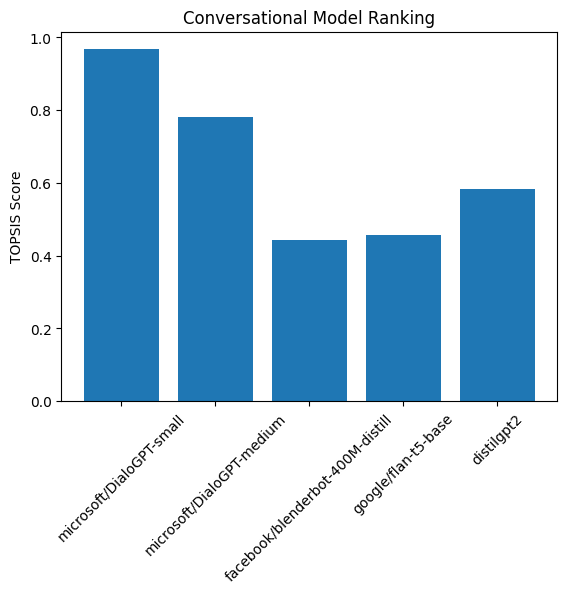

In [36]:
plt.figure()
plt.bar(df["Model"], df["TOPSIS_Score"])
plt.xticks(rotation=45)
plt.ylabel("TOPSIS Score")
plt.title("Conversational Model Ranking")
plt.show()


In [37]:
df.to_csv("topsis_results.csv", index=False)


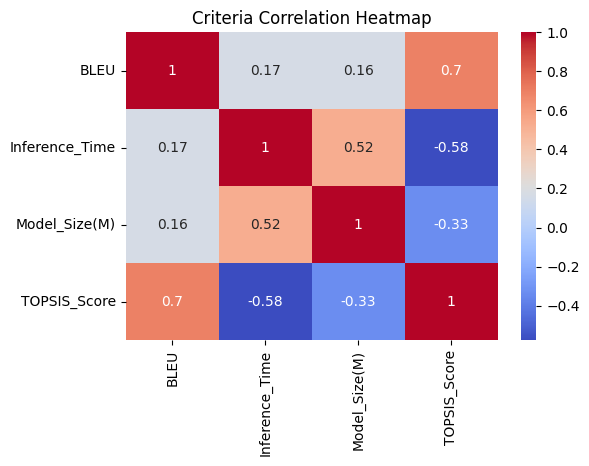

In [38]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.heatmap(df[["BLEU","Inference_Time","Model_Size(M)","TOPSIS_Score"]].corr(), annot=True, cmap="coolwarm")
plt.title("Criteria Correlation Heatmap")
plt.savefig("criteria_correlation.png")
plt.show()


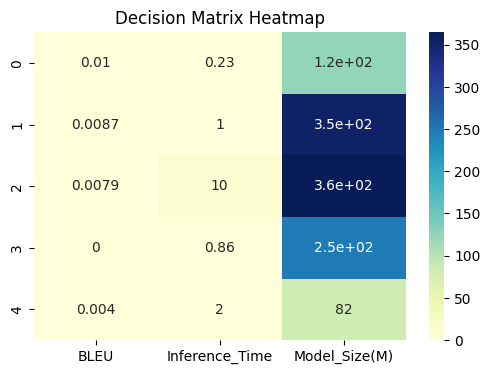

In [39]:
plt.figure(figsize=(6,4))
sns.heatmap(df[["BLEU","Inference_Time","Model_Size(M)"]], annot=True, cmap="YlGnBu")
plt.title("Decision Matrix Heatmap")
plt.savefig("decision_matrix_heatmap.png")
plt.show()


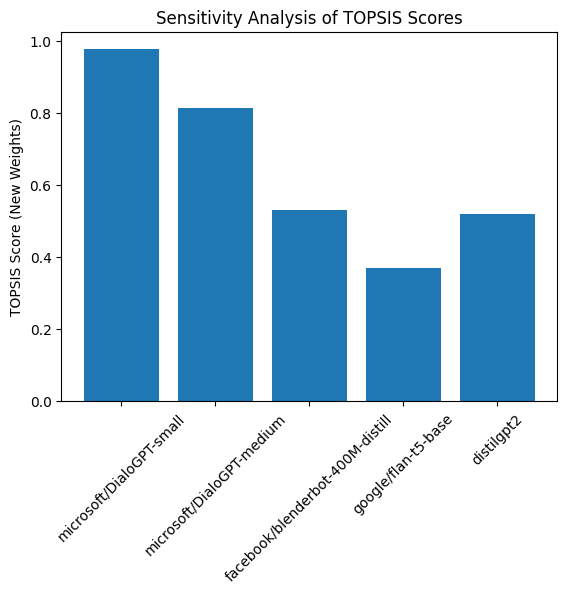

In [40]:
# Slightly changed weights
new_weights = np.array([0.6, 0.25, 0.15])

norm_matrix = decision_matrix / np.sqrt((decision_matrix**2).sum(axis=0))
weighted_matrix = norm_matrix * new_weights

ideal_best = np.array([
    weighted_matrix[:,0].max(),
    weighted_matrix[:,1].min(),
    weighted_matrix[:,2].min()
])

ideal_worst = np.array([
    weighted_matrix[:,0].min(),
    weighted_matrix[:,1].max(),
    weighted_matrix[:,2].max()
])

dist_best = np.sqrt(((weighted_matrix - ideal_best)**2).sum(axis=1))
dist_worst = np.sqrt(((weighted_matrix - ideal_worst)**2).sum(axis=1))

new_topsis = dist_worst / (dist_best + dist_worst)

plt.figure()
plt.bar(df["Model"], new_topsis)
plt.xticks(rotation=45)
plt.ylabel("TOPSIS Score (New Weights)")
plt.title("Sensitivity Analysis of TOPSIS Scores")
plt.savefig("sensitivity_analysis.png")
plt.show()


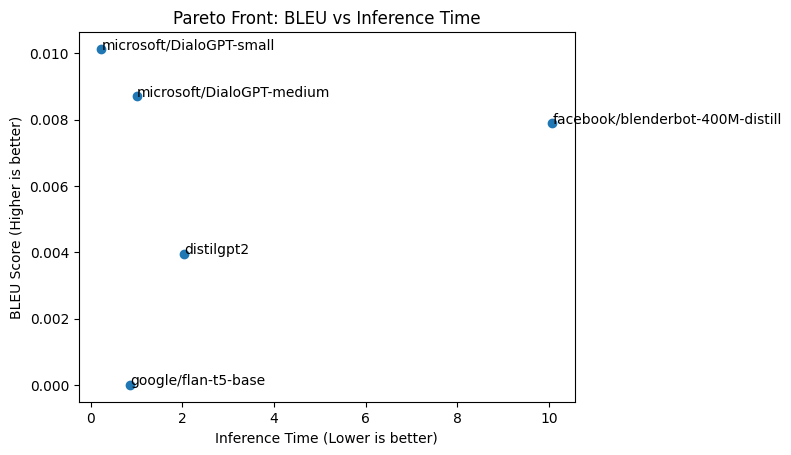

In [41]:
plt.figure()
plt.scatter(df["Inference_Time"], df["BLEU"])

for i, txt in enumerate(df["Model"]):
    plt.annotate(txt, (df["Inference_Time"][i], df["BLEU"][i]))

plt.xlabel("Inference Time (Lower is better)")
plt.ylabel("BLEU Score (Higher is better)")
plt.title("Pareto Front: BLEU vs Inference Time")
plt.savefig("pareto_front.png")
plt.show()


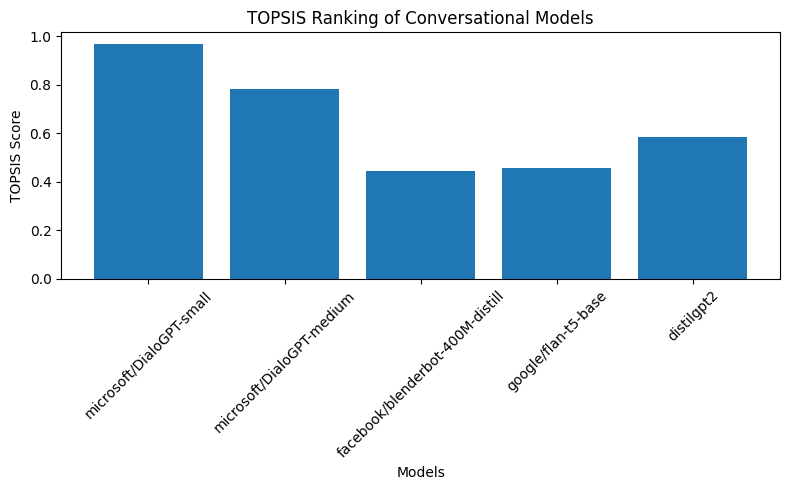

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.bar(df["Model"], df["TOPSIS_Score"])

plt.xticks(rotation=45)
plt.xlabel("Models")
plt.ylabel("TOPSIS Score")
plt.title("TOPSIS Ranking of Conversational Models")

plt.tight_layout()
plt.savefig("topsis_ranking.png")  # Saves image
plt.show()


In [43]:
df

,Model,BLEU,Inference_Time,Model_Size(M),TOPSIS_Score,Rank
0,microsoft/DialoGPT-small,0.010133,0.234554,124.439808,0.967563,1.0
1,microsoft/DialoGPT-medium,0.008710,1.009464,354.823168,0.781382,2.0
2,facebook/blenderbot-400M-distill,0.007885,10.067546,364.802560,0.443650,5.0
3,google/flan-t5-base,0.000000,0.863119,247.577856,0.455654,4.0
4,distilgpt2,0.003955,2.040678,81.912576,0.583783,3.0
